## Topic Modelling

We have downloaded some speeches by B. Obama and M. Romney made during US Presidential election 2012. The speeches are uploaded on GitHUB and we would try to find some imortant topics each of their speeches consisted of. We will do Topic modelling using Gensim and visualize these topics using a womderful package called pyLDAvis.

In [131]:
# Find folders and text under a given path
import os

# For dataframe/tables
import pandas as pd
import numpy as np

# Default dictionary
from collections import defaultdict

# Gensim
from gensim import corpora
from gensim import models

# Model evaluation
from gensim.models import CoherenceModel

# Visualization
from matplotlib import pyplot as plt
#from wordcloud import WordCloud

import pyLDAvis
import pyLDAvis.gensim
pyLDAvis.enable_notebook()


In [75]:
# corpus folder
folder = 'tmp'

# Corpus 
corpus_bow = dict()

# Load the corpus
for fld in next(os.walk(folder))[1] :
    for corpus in os.listdir(folder + os.sep + fld):
        file = os.getcwd() + os.sep + folder + os.sep + fld + os.sep + corpus
        if os.path.splitext(file)[1] == '.mm' :
            corpus_bow[fld] = list(corpora.mmcorpus.MmCorpus(file))            

# dictionary 
for item in next(os.walk(folder))[2] :
    file = os.getcwd() + os.sep + folder + os.sep + item
    if os.path.splitext(file)[1] == '.dict' :        
        corpus_dict = corpora.Dictionary.load(file)


In [76]:
# Transform corpus to Tf-idf
corpus_tfidf = dict()
for fld in corpus_bow.keys() :    
    Tfidf = models.TfidfModel(corpus_bow[fld], smartirs='ntc')
    corpus_tfidf[fld] = Tfidf[corpus_bow[fld]]    


In [77]:
#corpus_dict[id]
textlist = dict()
for fld in corpus_tfidf.keys() :
    textlist[fld] = [[corpus_dict[text_tup[0]] for text_tup in doc for _ in range(int(text_tup[1]))] for doc in corpus_bow[fld]]

In [95]:
# LDA model - evaluate coherence for different number of topics
num_of_passes = 10
x = defaultdict(list); y = defaultdict(list); z = defaultdict(list)
for fld in corpus_tfidf.keys() :
    for num_topics in range(5,20,1) :
        lda_model = models.LdaModel(corpus_tfidf[fld], id2word=corpus_dict, num_topics=num_topics, passes = num_of_passes,\
                                  chunksize=100, random_state=123, update_every=1)
        coherence_model_lda = CoherenceModel(model=lda_model,texts = np.squeeze(textlist[fld]), dictionary=corpus_dict, coherence='c_v')
        coherence_score = coherence_model_lda.get_coherence()        
        x[fld].append(num_topics) ; y[fld].append(coherence_score)
        print("{}'s speech : Number of topics is {}, coherence score is {}".format(fld,num_topics,coherence_score))


romney's speech : Number of topics is 5, coherence score is 0.6574311275799759
romney's speech : Number of topics is 6, coherence score is 0.6401647326180719
romney's speech : Number of topics is 7, coherence score is 0.5200713283513657
romney's speech : Number of topics is 8, coherence score is 0.6605303988906828
romney's speech : Number of topics is 9, coherence score is 0.6503916687668478
romney's speech : Number of topics is 10, coherence score is 0.5686472461172393
romney's speech : Number of topics is 11, coherence score is 0.5856653088456653
romney's speech : Number of topics is 12, coherence score is 0.6063284790387485
romney's speech : Number of topics is 13, coherence score is 0.5489878571824715
romney's speech : Number of topics is 14, coherence score is 0.5864512111727479
romney's speech : Number of topics is 15, coherence score is 0.5586578044480234
romney's speech : Number of topics is 16, coherence score is 0.5365315182261232
romney's speech : Number of topics is 17, coh

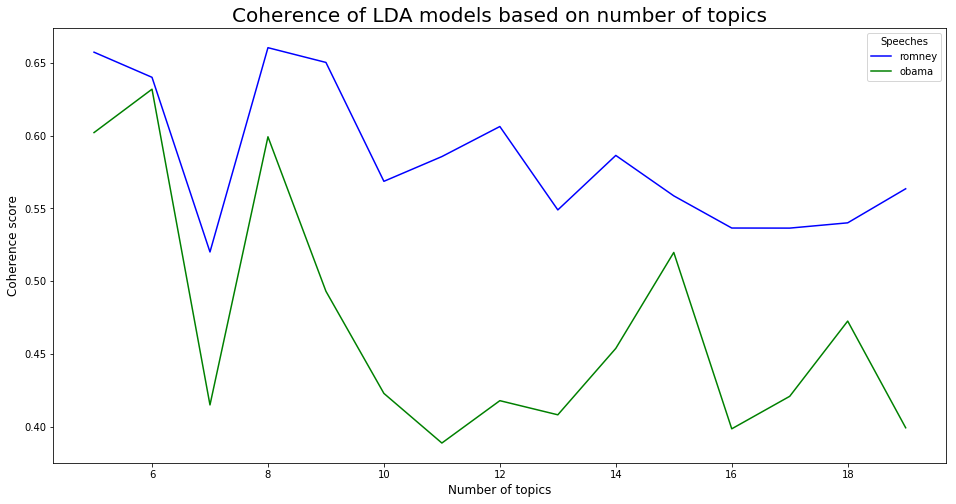

In [96]:
# Plot the coherence
plt.figure(figsize=(16,8))
col = dict()
col['obama'] = 'green'; col['romney'] = 'blue'
for fld in corpus_tfidf.keys() :
    plt.plot(x[fld],y[fld], color=col[fld], label=fld)
plt.legend(title='Speeches')
plt.title("Coherence of LDA models based on number of topics", fontsize=20)
plt.ylabel("Coherence score",fontsize=12)
plt.xlabel("Number of topics",fontsize=12)
plt.show()

In [97]:
# LDA - final model
num_of_passes = 10
lda = dict(); num_topics = dict()
num_topics['obama'] = 8;  num_topics['romney'] = 8
num_words = 15

for fld in corpus_tfidf.keys() :
    lda[fld] = models.LdaModel(corpus_tfidf[fld], id2word=corpus_dict, num_topics=num_topics[fld], passes = num_of_passes,\
                              chunksize=100, random_state=123, update_every=1)
    model_perplexity = lda_model.log_perplexity(corpus_tfidf[fld])
    print("Model perplexity for {} is {}".format(fld,model_perplexity))


Model perplexity for romney is -21.697229022576508
Model perplexity for obama is -16.705650662669804


In [122]:
topics = lda['romney'].show_topics(formatted=False, num_words = num_words)
topics

[(0,
  [('falcon', 0.00074157066),
   ('berta', 0.00074157026),
   ('derrick', 0.00043862505),
   ('option', 0.00038810086),
   ('response', 0.00036098083),
   ('prairie', 0.0003315945),
   ('redundancy', 0.00030938716),
   ('retiree', 0.00030657096),
   ('liability', 0.00029341984),
   ('insurance', 0.00028770976),
   ('waste', 0.00026726007),
   ('marry', 0.00026564894),
   ('mother_father', 0.00025448794),
   ('frankly', 0.00025368287),
   ('inaud', 0.00025361634)]),
 (1,
  [('apologies', 0.0019219369),
   ('request', 0.0016862898),
   ('search', 0.001568411),
   ('nothing', 0.0015650911),
   ('perhaps', 0.0014071622),
   ('leave_reply', 0.0014011151),
   ('cancel_reply', 0.0014011114),
   ('comment_closed', 0.0010766448),
   ('found', 0.00085704966),
   ('applause', 0.000725984),
   ('kerry', 0.00063515693),
   ('unfairness', 0.00057050335),
   ('audience', 0.00054519455),
   ('liberal', 0.00045992254),
   ('abortion', 0.0004429648)]),
 (2,
  [('library', 0.00067965756),
   ('valle

In [118]:
# Display the topics and words associated
for fld in corpus_tfidf.keys() :  
    print('*'*80)
    print(fld.upper())
    print(pd.DataFrame({"Topic "+ str(i+101)[1:]:[topic[0] for topic in lda[fld].show_topic(i,num_words)] \
                                    for i in range(num_topics[fld])}, index = [i+1 for i in range(num_words)] ))

********************************************************************************
ROMNEY
         Topic 01        Topic 02      Topic 03        Topic 04     Topic 05  \
1          falcon       apologies       library        religion        guard   
2           berta         request        valley           peace     remember   
3         derrick          search         plant         nuclear       living   
4          option         nothing       society          church  commonsense   
5        response         perhaps    transcript       religious        sheet   
6         prairie     leave_reply    imaginable           marry       martha   
7      redundancy    cancel_reply        little          threat        apart   
8         retiree  comment_closed  presidential        abortion   retirement   
9       liability           found        center         israeli    desperate   
10      insurance        applause         glass           merit      portman   
11          waste           kerr

In [99]:
# Visualize - LDA using pyLDAvis
vis = dict()
for fld in corpus_tfidf.keys() :
    vis[fld] = pyLDAvis.gensim.prepare(lda[fld],corpus=corpus_tfidf[fld],dictionary=corpus_dict, mds = 'mmds')

C:\Users\acer\Anaconda3\envs\py35\lib\site-packages\pyLDAvis\_prepare.py:257: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  return pd.concat([default_term_info] + list(topic_dfs))


In [100]:
# Print topics in Romney's speeches
print(list(corpus_tfidf.keys())[0])
vis[list(corpus_tfidf.keys())[0]]

romney


PreparedData(topic_coordinates=            Freq  cluster  topics         x         y
topic                                                
7      32.286922        1       1 -0.010916  0.012551
6      23.089296        1       2  0.004845  0.008896
3      15.599465        1       3  0.008407 -0.003125
1       8.143544        1       4 -0.006476 -0.005140
2       8.095627        1       5  0.003485 -0.001110
5       4.474410        1       6  0.000015 -0.002372
0       4.413577        1       7 -0.001010 -0.004982
4       3.897159        1       8  0.001651 -0.004718, topic_info=     Category      Freq            Term     Total  loglift  logprob
term                                                               
5526  Default  0.000000       apologies  0.000000  30.0000  30.0000
7537  Default  0.000000         request  0.000000  29.0000  29.0000
3908  Default  0.000000          search  0.000000  28.0000  28.0000
3114  Default  0.000000         nothing  0.000000  27.0000  27.0000
7364  Default  0.000000         perhaps  0.000000  26.0000  26.0000
5215  Default  0.000000    cancel_reply  0.000000  25.0000  25.0000
7216  Default  0.000000     leave_reply  0.000000  24.0000  24.0000
6121  Default  0.000000        applause  0.000000  23.0000  23.0000
6892  Default  0.000000  comment_closed  0.000000  22.0000  22.0000
3785  Default  0.000000           found  0.000000  21.0000  21.0000
6455  Default  0.000000          falcon  0.000000  20.0000  20.0000
3625  Default  0.000000           berta  0.000000  19.0000  19.0000
3547  Default  0.000000        religion  0.000000  18.0000  18.0000
4905  Default  0.000000          nevada  0.000000  17.0000  17.0000
410   Default  0.000000         library  0.000000  16.0000  16.0000
240   Default  0.000000    conservative  0.000000  15.0000  15.0000
756   Default  0.000000         liberal  0.000000  14.0000  14.0000
4663  Default  0.000000           kerry  0.000000  13.0000  13.0000
5407  Default  0.000000           guard  0.000000  12.0000  12.0000
6475  Default  0.000000     immigration  0.000000  11.0000  11.0000
1054  Default  0.000000          valley  0.000000  10.0000  10.0000
1124  Default  0.000000        remember  0.000000   9.0000   9.0000
4397  Default  0.000000        audience  0.000000   8.0000   8.0000
6683  Default  0.000000      unfairness  0.000000   7.0000   7.0000
741   Default  0.000000      philosophy  0.000000   6.0000   6.0000
7625  Default  0.000000         derrick  0.000000   5.0000   5.0000
4730  Default  0.000000        abortion  0.000000   4.0000   4.0000
3083  Default  0.000000        strategy  0.000000   3.0000   3.0000
1175  Default  0.000000           plant  0.000000   2.0000   2.0000
1660  Default  0.000000         veteran  0.000000   1.0000   1.0000
...       ...       ...             ...       ...      ...      ...
905    Topic8  0.009274           smell  0.099001   0.8770  -8.2370
867    Topic8  0.009402        disgrace  0.102738   0.8537  -8.2233
3082   Topic8  0.009151          dorene  0.100020   0.8534  -8.2504
5353   Topic8  0.009231     superiority  0.103113   0.8316  -8.2417
4928   Topic8  0.008735         refrain  0.098862   0.8186  -8.2969
5219   Topic8  0.008735          bigger  0.098867   0.8184  -8.2970
3869   Topic8  0.008729          amidst  0.098902   0.8174  -8.2977
5107   Topic8  0.008728         bloated  0.098906   0.8173  -8.2977
6907   Topic8  0.008727   disappointing  0.098910   0.8172  -8.2978
5136   Topic8  0.008716           lofty  0.098980   0.8152  -8.2991
4222   Topic8  0.008657           motor  0.098527   0.8130  -8.3059
7313   Topic8  0.008657         hampton  0.098528   0.8129  -8.3060
7506   Topic8  0.008656     eligibility  0.098530   0.8128  -8.3060
1131   Topic8  0.008699          bitter  0.099086   0.8121  -8.3011
1822   Topic8  0.008697         granite  0.099097   0.8118  -8.3013
2445   Topic8  0.009871          spouse  0.113552   0.8023  -8.1747
182    Topic8  0.009296      everywhere  0.108864   0.7844  -8.2347
96     Topic8  0.

In [101]:
# Print topics in Obama's speeches
print(list(corpus_tfidf.keys())[1])
vis[list(corpus_tfidf.keys())[1]]

obama


PreparedData(topic_coordinates=            Freq  cluster  topics         x         y
topic                                                
0      92.169960        1       1 -0.052861  0.072964
5       1.361022        1       2  0.007335 -0.010692
7       1.346416        1       3  0.007934 -0.009666
2       1.139884        1       4  0.007580 -0.010530
1       1.081649        1       5  0.007424 -0.010574
4       1.023111        1       6  0.007496 -0.010530
3       0.971333        1       7  0.007644 -0.010458
6       0.906633        1       8  0.007448 -0.010515, topic_info=     Category      Freq             Term     Total  loglift  logprob
term                                                                
4113  Default  2.000000          tonight  2.000000  30.0000  30.0000
4447  Default  0.000000          reclaim  0.000000  29.0000  29.0000
3797  Default  0.000000          bravely  0.000000  28.0000  28.0000
2380  Default  0.000000          creator  0.000000  27.0000  27.0000
1595  Default  0.000000            wedge  0.000000  26.0000  26.0000
2166  Default  0.000000     independents  0.000000  25.0000  25.0000
4608  Default  0.000000         generous  0.000000  24.0000  24.0000
6151  Default  0.000000          shatter  0.000000  23.0000  23.0000
1963  Default  0.000000      scholarship  0.000000  22.0000  22.0000
8014  Default  0.000000            choke  0.000000  21.0000  21.0000
4943  Default  0.000000        diversity  0.000000  20.0000  20.0000
8173  Default  0.000000           beacon  0.000000  19.0000  19.0000
2335  Default  0.000000          peddler  0.000000  18.0000  18.0000
5277  Default  0.000000            count  0.000000  17.0000  17.0000
883   Default  1.000000          hostage  1.000000  16.0000  16.0000
3169  Default  1.000000         pluribus  1.000000  15.0000  15.0000
7028  Default  1.000000            endow  1.000000  14.0000  14.0000
8140  Default  1.000000          singing  1.000000  13.0000  13.0000
1467  Default  1.000000            naval  1.000000  12.0000  12.0000
1984  Default  1.000000          premise  1.000000  11.0000  11.0000
2483  Default  1.000000      inalienable  1.000000  10.0000  10.0000
4251  Default  1.000000           mekong  1.000000   9.0000   9.0000
6798  Default  1.000000          worship  1.000000   8.0000   8.0000
1760  Default  1.000000          evident  1.000000   7.0000   7.0000
1801  Default  1.000000          bedrock  1.000000   6.0000   6.0000
3593  Default  1.000000          willful  1.000000   5.0000   5.0000
4809  Default  1.000000    individualism  1.000000   4.0000   4.0000
5608  Default  1.000000            coach  1.000000   3.0000   3.0000
1553  Default  1.000000      retribution  1.000000   2.0000   2.0000
5494  Default  1.000000           skinny  1.000000   1.0000   1.0000
...       ...       ...              ...       ...      ...      ...
3073   Topic8  0.001415           harper  0.077434   0.7008  -9.0262
3072   Topic8  0.001415      enforceable  0.077434   0.7008  -9.0262
6246   Topic8  0.001415            forma  0.077434   0.7008  -9.0262
6247   Topic8  0.001415           wahabi  0.077434   0.7008  -9.0262
460    Topic8  0.001415            erase  0.077434   0.7008  -9.0262
3400   Topic8  0.001415           caucas  0.077434   0.7008  -9.0262
1080   Topic8  0.001415          perkins  0.077434   0.7008  -9.0262
3402   Topic8  0.001415            sport  0.077434   0.7008  -9.0262
3371   Topic8  0.001415  radical_violent  0.077434   0.7008  -9.0262
5387   Topic8  0.001415           mantel  0.077434   0.7008  -9.0262
1386   Topic8  0.001415            assad  0.077434   0.7008  -9.0262
5368   Topic8  0.001415           caring  0.077434   0.7008  -9.0262
5381   Topic8  0.001415            latin  0.077434   0.7008  -9.0262
5234   Topic8  0.001415            sided  0.077434   0.7008  -9.0262
5352   Topic8  0.001415            waldo  0.077434   0.7008  -9.0262
651    Topic8  0.001415      operational  0.077434   0.7008  -9.0262
18     Topic8  0.001458       relent